# Vector Autoregressive Models (VAR)

When we work with time series, we are often working with multiple time series that depend on one another (in statistics, we call these *endogenous* variables). As a first attempt, we could simply include one or more additional factors as regressors in our regression equation to try and explain the fluctuation in our dependent variable.

This works when the additional series are exogenous. Is this always the case, though? In many contexts, we may deal with multiple time series which contain feedback loops. While $x$ can be shown to drive changes in $y$, we also have to consider that $y$ may be driving changes in $x$ as well. In this case, our variables are endogenous, and this will cause problems in our model. This is bad because endogeneity is a violation of the OLS assumptions. On the other hand, this isn't TOO bad, because we have models that can rescue us from our data.

Before we get to the time series versions, though, we need to understand how endogenous regressors can be handled generally. We can then explore time series models that take advantage of these adaptations in our forecasting context.

## Seemingly Unrelated Regressions (SUR)

When we need to estimate two unknowns in a system of equations, we need two different equations (at least!). The solution to our regression problem, then, is to create a series of regression equations that can be estimated simultaneously as a **system of equations**, with the resulting model providing predictions for each dependent variable relative to the other(s).

We can write these equations as follows:

$$ Y_{j} = X_j\beta_j + \epsilon_j $$

where $Y_j$, and $\epsilon_j$ are $N \times 1$, $X_j$ is $N \times K$,  and $\beta_j$ is $K \times 1$. Additionally, there are $j$ regression equations. Note that there isn't really anything special about the equations, per se, the only new thing going on here is that there is **more than one** regression equation.

Additionally, our error terms are correlated, because our dependent variables are to some extent related to one another. Thus, inaccuracy in one model is correlated with inaccuracy in the other model(s). We can express this correlation mathematically:

$$ Cov(\epsilon_{ij}, \epsilon_{ik})=\sigma_{ij}$$
and 
$$ Cov(\epsilon_{ij}, \epsilon_{i'k})=0, \;\;\forall \;i \neq i'$$

In a nutshell, this just tells us that errors may be correlated from one dependent variable to another across regression equations **for the same observation**. We assume that correlation across observations is 0, so that our observations remain (in theory) independent and identically distributed.

At this point, we stack up all of our regression equations into a bunch of really big matrices:


$$ \begin{bmatrix} Y_1 \\ Y_2 \\ \vdots \\ Y_{N}\end{bmatrix} = \begin{bmatrix} X & \mathbf{0} & ... & \mathbf{0}  \\ \mathbf{0} & X & ... & \mathbf{0}  \\ \vdots & \vdots & \ddots & \mathbf{0} \\ \mathbf{0} & \mathbf{0} & \mathbf{0} & X  \end{bmatrix} \begin{bmatrix} \beta_1 \\ \beta_2 \\ \vdots \\ \beta_{N}\end{bmatrix} + \begin{bmatrix} \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_{N}\end{bmatrix}$$

Where $Y_j$ is a vector of length $N$, and $X$ is an $N \times K$ matrix, so that the full array of $Y$s are $(N\cdot J) \times 1$, and the enlarged $X$ matrix is  $(N\cdot J) \times (K\cdot J) $

The FGLS (Feasible Generalized Least Squares) estimator of the system is 

$$ \hat{\beta}_{FGLS} = \left( X'\left(\hat{\Sigma} \otimes I_N\right)X  \right)^{-1} X'\left(\hat{\Sigma} \otimes I_N\right)Y $$

<br>

Where $\hat{\Sigma} = [\hat{\sigma}_{ij}]$, and

$$ \hat{\sigma}_{ij} = \frac{1}{N}\left(y_i - X_i\beta_i\right)'\left(y_j - X_j\beta_j\right) $$

Ignore that math, though. All we are doing is jointly conducting least squares regression on a group of regression equations while allowing for the fact that several of the variables are endogenously determined. The end result is essentially just a **collection** of regression tables, with one table for each of the specified dependent variables.

## Back to a Time Series

So what is all of this for? It turns out that one of the most common places to see dependent variables affecting one another is in a time series context. Think of pollution data: temperature affects air pressure and also wind speed, but wind speed may affect temperature, and air pressure may also affect temperature as it draws in or repels cold fronts. As one variable changes, so do the others. 

As we seek to predict one or more of these values, we also need to predict the others. To do this, we need to create a time series version of the SUR model. The simplest version of this model is called the **VAR model, or Vector Autoregressive model**. A small extension (including possible moving average terms) leads us to the **VARMA** model.

Let's talk about how these models work.

## Autocorrelation and AutoRegressive (AR) Models
### You know what they say about assumptions...

When we use OLS models, we are making five assumptions, which are often called the **standard assumptions**. These assumptions are required in order to mathematically derive the OLS regression solution. These rules are (according to *Econometric Analysis* by William Greene):

1) There must be a linear relationship between the dependent variable and any independent variable (that's why it's called **linear** regression!!)

2) Full rank (you can't recreate any $x$ variables through a linear combination of other $x$ variables)

3) Errors have mean zero. The error term for one observation $\epsilon_i$ cannot be predicted by $x$ variables. 

4) Every error term $\epsilon_i$ is unrelated to any other error term $\epsilon_j$, and each error term has the same variance $\sigma$. Violations of these combined conditions are called autocorrelation and heteroskedasticity, respectively. Autocorrelation, in particular, is crucial in a time-series context.

5) Errors are normally distributed. Probably the easiest assumption to violate. Kind of like a speeding ticket...

<br>

While these assumptions are important, they are NOT required in order to perform regression! In fact, they are often more important (and interesting) in the usefulness of their violations (and the solutions to those new models) than they are in a list like this one. It's just important that you know they exist before we go breaking them and making newer and more exciting models.

### More like guidelines than real rules

In many (most?) cases, we want to work with data that demonstrably violate some of these assumptions. That is fine! Just a few points, though...
- OLS is no longer guaranteed to model "truth" once the assumptions are violated (that seems bad...)
- There are models that have been developed to deal with nearly every possible way of violating these assumptions
- We will discuss those that are most relevant to forecasting (yay!)

<br>

Now that we know this, we just need to figure out whether time-series data (the kind of data we are going to focus on in the first half of this course) violates any of these rules. Knowing what is broken enables us to focus on finding a way to model our data that does not depend on the violated assumption. 

### So how about time-series data?

Let's start by understanding what time-series data actually is. Strictly speaking, time-series data is data focused on a **single variable**, and tracking the value of that variable over time. We also frequently call data time-series data if it is a collection of variables tracked over time. Let's take a look at some time-series data:

In [1]:
import pandas as pd
import plotly.express as px

# The full data set is ~30 Mb so this might not be fast...
# Grab the last year of the data
data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/omahaNOAA.csv")
# Clean it up
data = data.loc[len(data)-365*24:, ['DATE', 'HOURLYDRYBULBTEMPC']]
data.columns = ['date', 'temp_c']
data = data.loc[data['temp_c']!=0] # temp=0 is a 'missing value', which is annoying but fixable
data['date'] = pd.to_datetime(data['date'])
# And plot it
px.scatter(data, x='date', y='temp_c')

What is the first thing you notice about this plotted data? Does it help if we look at a smaller subset?

In [2]:
px.scatter(data[-100:], x='date', y='temp_c')

What stands out to me about this data is that there is a **pattern** from one observation to the next. This might seem obvious, but it is a really important point about time-series data. Whenever our data is more than noise that has been sampled over time, our time-series data will have a pattern.

In math speak, we might say something like

$$ Corr(x_t, x_{t+1}) \neq 0 $$

This is a lot like what we assumed does NOT happen in our data under assumption (4) earlier! We can also write this relationship in a way that helps us to start understanding how we might implement regression with time-series data:

$$ y_{t} = \rho \cdot y_{t-1} + \epsilon_t $$

Where $\rho$ is the correlation between one observation and the next, and $\epsilon_t$ is the error or noise term.

Let's describe this in plain English. When we work with time-series data, we frequently observe that one observation is correlated with the next observation in the sequence. Because observations are correlated, our data is **not** independent and identically distributed, and therefore the standard assumptions of OLS **do not hold**. Without the standard assumptions OLS is no longer assured to represent our best approximation of truth. We can do better.

## Upgrading OLS for time-series

One of the best ways to account for violations of the standard assumptions is to eliminate the violation of the assumption from our data, and then use OLS. We are going to construct a new model that will do exactly that in order to deal with time-series data. This will enable us to take advantage of the interpretability of OLS models, while also using more interesting data to make forecasts.

### AutoRegressive Models

Our weather data is clearly correlated from one period to the next. The temperature in an hour is highly correlated with the temperature right now. The temperature tomorrow is also correlated (less strongly) with the current temperature. This suggests that the best way to describe our data-generating process is with the equation from above:

$$ y_{t} = \rho \cdot y_{t-1} + \epsilon_t $$

Which also **implicitly** mandates that there be correlation between the current period and **all past time periods**:

$$ y_{t} = \rho \cdot y_{t-1} + \epsilon_t = \rho \cdot (\rho \cdot y_{t-2}) + \epsilon_t $$
$$ = \rho \cdot (\rho \cdot (\rho \cdot y_{t-3})) + \epsilon_t = ... = \alpha + \rho^i \cdot y_{t-i} + \epsilon_t $$

Today's weather is correlated with the weather in every time period that has ever happened before.

The solution to this particular problem with our data is to use an __A__uto**R**egressive (AR) model. AR models are specified to contain a chosen number of lagged observations of $y$ as explanatory variables (they become our $x$ variables), and to use those lags to predict the next value of $y$ in the time-series.

By choosing the number of lags in an AR model, we are specifying how quickly we expect a time-series to return to its mean value. The fewer lagged terms we include, the quicker we expect the mean reversion to occur. The number of lagged observations is called the **order** of the model, and is denoted ($p$). When we describe models as AR($p$), we say that they are AutoRegressive models of order $p$:

$$ AR(p) \implies y_t = \alpha + \sum_{i=1}^p \rho_i \cdot y_{t-i} + \epsilon _t$$

In practice we allow $\rho_i$ to be estimated independently of all other $\rho$ values. We will wait to estimate AR models until we have a more complete picture of time series data.

### Moving Average Models

Brace yourselves. The Moving Average (MA) model may look almost exactly like an AR model, but its subtle differences can be very valuable additions to a time-series model.

AR models assume that the current value of $y$ is correlated with past values of $y$. In an MA model, $y_t$ is instead correlated with the **past error term** $\epsilon_{t-1}$. We can express this mathematically:

$$ y_t = \theta \cdot \epsilon_{t-1} + \epsilon_t $$

What is the difference? We know that $\epsilon_t$ is statistical noise. It represents the deviation of truth from our expectations in time $t$. We also know that it has an expected value of zero, so that our expectations should be correct **on average**. I $\epsilon$ is built from $y$, then how is this different from an AR model?

MA models derive their predictions of tomorrow from the errors of today. Because of this, our model **does not** incorporate persistent information from every previous period, like an AR model. The information about deviation from yesterday is sufficient.

Like an AR model, we can choose the **order** of our MA model by incorporating additional error terms from past periods into our model. In the case of the MA model, the order is denoted $q$.

$$ MA(q) \implies y_t = \alpha + \sum_{i=1}^q \theta_i \cdot \epsilon_{t-i} + \epsilon_t $$

Because errors are uncorrelated with one another, we will estimate each $\theta$ term independently in our model. 



## VAR(MA) Models

Remember from our lessons on ARIMA models that most time series $y$ suffer from autocorrelation. This means that $y_t$ is correlated with $y_{t-1}$, and through it all other previous observations of the series. If we have a group of time series variables, then each of the variables are likely to have this same characteristic.

Thus, our elementary SUR model, where a single observation is correlated across dependent variables but not across observations is invalid. Our model now requires us to account for correlation both across dependent variables, as well as over time (ie across observations). What we end up with is the **VARMA** (Vector AutoRegressive Moving Average) model. The best way to start describing a VARMA model is to simply write it out mathematically. Let's start by writing a VARMA(1, 0) or VAR(1) model, where there is a single AR term for each dependent variable:

$ \mathbf{y}_{i,t} = \mathbf{\mu_i} + \mathbf{\Gamma}_{i,1} \mathbf{y}_{i,t-1} + \sum_{j=1}^{J}\mathbf{\Gamma}_{j,1} \mathbf{y}_{i, t-1} + \mathbf{\epsilon}_{i,t}  $

where $i \neq j$. That means that for any specific $y$ function, we consider its one-period lag, as well as the first lagged value of all other $y$'s as explanatory variables.

By creating this special case of the SUR model to account for the tendencies of time series data, we are able to allow endogeneity across variables, as well as autocorrelation across time. 

This approach will become even more impressive as we look at the models themselves, and at how they enable us to explore the impact of possible shocks to the system through our statistical model.

## Implementing a VARMA model

As we build out our statistical models, there is one important distinction between VARMA and ARIMA models that we should consider: an ARIMA model allows us to deal with non-stationary data **through** our model. A VARMA model provides no such mechanism. This is because a VARMA model deals with many endogenous variables simultaneously. Just because one variable is non-stationary does not mean that we should difference **every** dependent variable!

In practice, this means that we must check our variables for stationarity before implementing a VARMA model. If we find our time series to be non-stationary, then we must create a differenced time series prior to incorporating a variable into our model.

And now, to the code:


In [3]:
# Getting started by importing modules and data

import pandas as pd, numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import plotly.express as px
from datetime import datetime

# Collect data, set index

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/raw/master/DataSets/pollutionBeijing.csv")
                   
format = '%Y-%m-%d %H:%M:%S'
data['datetime'] = pd.to_datetime(data['datetime'], format=format)
data.set_index(pd.DatetimeIndex(data['datetime']), inplace=True)

# Select variables for VAR model
varData = data[['pm2.5','TEMP','PRES','Iws']].dropna()[:-50]

Note that we do not use patsy when preparing data for our VARMA model. This is because we must pass an **array** of dependent variables to our model, and this can be more easily done by selecting pre-processed columns from our data frame. 

Additionally, we are dropping missing values and the last fifty observations (the last 50 will be used to evaluate our forecast).

With many variables, it becomes burdenson to visually diagnose each individual time series based on its visual characteristics using ACF and PACF plots. We will take this opportunity to use the built-in functionality of `statsmodels` to calculate the AIC- and BIC-indicated optimal orders for our data. In order to do this, we must assume that our model has no Moving Average components. We then use the `VAR` model's inbuilt functionality as follows:


In [4]:
model = sm.tsa.VAR(varData) # define the model and data
print(model.select_order().summary()) # uses information criteria to select the model order

C:\Users\SandiSnapple\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        25.21       25.21   8.841e+10       25.21
1        11.97       11.97   1.578e+05       11.97
2        11.73       11.74   1.247e+05       11.74
3        11.59       11.60   1.079e+05       11.59
4        11.55       11.57   1.040e+05       11.56
5        11.54       11.56   1.029e+05       11.55
6        11.53       11.55   1.014e+05       11.53
7        11.52       11.54   1.003e+05       11.52
8        11.50       11.53   9.889e+04       11.51
9        11.48       11.51   9.705e+04       11.49
10       11.46       11.49   9.481e+04       11.47
11       11.43       11.47   9.206e+04       11.44
12       11.40       11.44   8.926e+04       11.41
13       11.37       11.42   8.690e+04       11.39
14       11.35       11.40   8.480e+04       11.36
15       11.32       11.37   8.268e+04       11.34
16       11.30       11.35   8.

Given that three of the criteria suggest a lag order near 50, I will choose 48 lags (hourly data, so 2 days of lags), and fit my model accordingly:

In [5]:
modelFit = model.fit(48) 
modelFit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Jan, 2026
Time:                     20:07:13
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    11.2901
Nobs:                     41659.0    HQIC:                   11.1806
Log likelihood:          -467508.    FPE:                    68190.3
AIC:                      11.1301    Det(Omega_mle):         66941.2
--------------------------------------------------------------------
Results for equation pm2.5
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             4.088929        27.508743            0.149           0.882
L1.pm2.5          1.127753         0.004923          229.077           0.000
L1.TEMP          -0.837321         0.097215           -8.613           0.000

Now, the tables are MASSIVE, because each table has 48 lags of each of the four variables! While this doesn't make for particularly useful inference based on reading tables, our model has been generated, and now we can create some pretty cool forecasts of future periods, and even conduct some exercises that will help us to understand how a shock to the system will impact our simultaneous estimation of these four variables.

In [6]:
forecastData = data[['pm2.5','TEMP','PRES','Iws']].dropna()[-100:-50]

fcast = pd.DataFrame(modelFit.forecast(y = forecastData.values,steps=50), columns = ['pm2.5','TEMP','PRES','Iws'])

Now we can create a vector of "truth", and compare our data from the forecast with the observed data from those future time periods.

In [7]:
truth = data[['pm2.5','TEMP','PRES','Iws']].dropna()[-50:]

# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['pm2.5'], truth['pm2.5']],
        title = 'Particulate Matter Forecast',
		labels = {
			'value' : 'Particulate Matter',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

In [8]:
# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['Iws'], truth['Iws']],
        title = 'Wind Speed Forecast',
		labels = {
			'value' : 'Wind Speed',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

In [9]:
# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['TEMP'], truth['TEMP']],
        title = 'Temperature Forecast',
		labels = {
			'value' : 'Temperature (C)',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

In [10]:
# Create and format the figure
fig = px.line(x = truth.index, 
		y=[fcast['PRES'], truth['PRES']],
        title = 'Air Pressure Forecast',
		labels = {
			'value' : 'Air Pressure',
			'x' : 'Date',
			'variable' : 'Series'
		})

# Renaming the series
fig.data[0].name = "Forecast"
fig.data[1].name = "Truth"

# Render the plot
fig.show()

Our VAR model does pretty well with this data! In the short term we can see that three of the four variables remain fairly close to their true values, while `pm2.5` deviates to a larger extent. Now that we have our forecasts in hand, let's add some exogenous factors to our model via the VARMAX model extension.

## VARMAX, or VARMA with Exogenous Variables

Just like the ARIMA, we can extend our VAR/VARMA models by adding exogenous variables into the mix. Using the VARMAX model, this is straightforward:

In [17]:
# Prep our data
varData = data[['pm2.5','TEMP','PRES','Iws', 'DEWP']].dropna()[-500:-50]
exog = varData['DEWP']
varData.drop('DEWP', axis=1, inplace=True)

# Create and fit model
model = sm.tsa.VARMAX(endog = varData.values, exog=exog.values, order=(48,0)) # define the order here for VARMAX!
modelFit = model.fit() 
modelFit.summary()

C:\Users\SandiSnapple\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



KeyboardInterrupt: 

Cool! Now we have all of the tools to build out VAR models of several flavors. With these tools in hand we can progress to impulse responses, and learning how to analyze the impact of a single shock to our system.

## Impulse Response Functions

What happens to temperature if it rains? What happens to wind speed? And pollution? When we utilize impulse response functions (IRFs) we can analyze the expected changes across our system that result from a single shock to one of our endogenous variables. The best way to learn is by doing, so let's make an IRF of increased rainfall and determine its effect on our system:

C:\Users\SandiSnapple\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

<positron-console-cell-16>:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



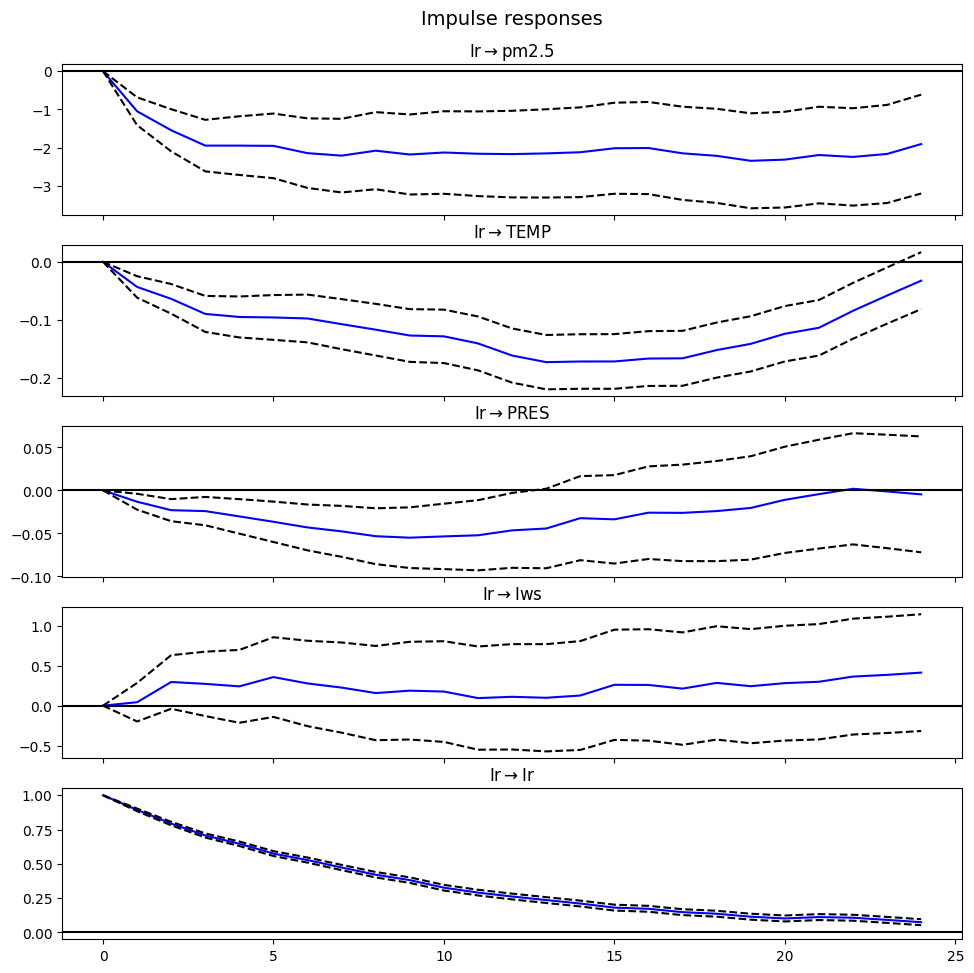

In [16]:
# Recreate our VAR model (though we can also use VARMAX models) with rainfall as a variable
# Select variables for VAR model
varData = data[['pm2.5','TEMP','PRES','Iws', 'Ir']].dropna()[:-50]

model = sm.tsa.VAR(varData) # define the model and data
modelFit = model.fit(48) 

# Create the impulse response functions
irf = modelFit.irf(24)
plt = irf.plot(impulse="Ir")
plt.show()

I personally wasn't surprised by the IRFs for rainfall. My general impression over my life has been that rain tends to clear the air (`pm2.5` falls after rain), and the temperature declines. The IRF is intriguing in the sense that it tells us the marginal effect of rainfall at each point in time following the original shock (at `t=0`).

Can we see the overall impact of rainfall? We can! There is also a Cumulative Response Function (CRF), which aggregates the overall impact of the shock, so that we can see where the "new normal" resides. This kind of study is particularly valuable when exploring economic outcomes, since events such as a demand shock will often leave a market at a new equilibrium, and we can estimate that outcome using a CRF.

<positron-console-cell-18>:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



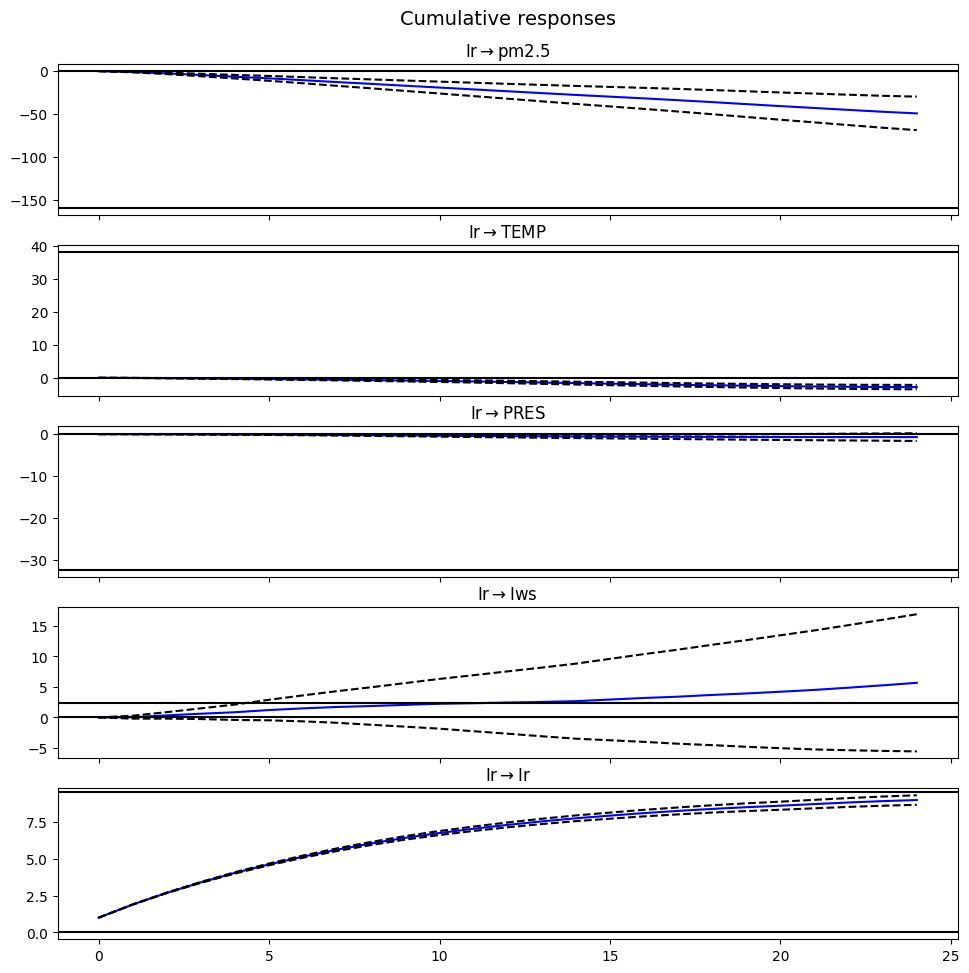

In [18]:
# Create the cumulative response functions
plt = irf.plot_cum_effects(impulse="Ir")
plt.show()

**Reading Assignment**

On Canvas, describe a case in which you might use VAR models in your work/education. How would you create the model? What data would you need? What would you learn if you used an IRF or CRF based on your model?